In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.models as models
import random as random
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from functools import reduce
from operator import __or__
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from PIL import Image

In [2]:
alignmnist = np.load('data/alignmnist.npz')
x = alignmnist['x']
y = alignmnist['y']

In [3]:
class AlignMNIST(Dataset):
    def __init__(self, data, target, transforms=None):
        self.data = data
        self.target = torch.from_numpy(target)
        self.transforms = transforms
        
    def __getitem__(self, index):
        img, label = self.data[index], self.target[index]
        img = Image.fromarray(img, mode='L')
        if self.transforms is not None:
            img = self.transforms(img)
        return (img, int(label))

    def __len__(self):
        return self.target.shape[0] # of how many data(images?) you have

In [4]:
n_labels = 10
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])

def get_mnist(location="./", batch_size=128):
    
    
    
    img_transform = lambda x: compose(x).view(-1)
    

    mnist_train = AlignMNIST(x[10000:], y[10000:], img_transform)
    mnist_valid = AlignMNIST(x[:10000], y[:10000], img_transform)

    # Dataloaders for MNIST
    train = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
    
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size)

    return train, validation

In [5]:
train_loader, valid_loader = get_mnist()

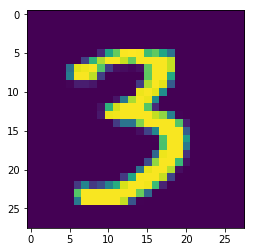

In [6]:
image, label = next(iter(train_loader))
plt.imshow(image[0].view(28,28))

In [7]:
class Classifier(nn.Module):
    def __init__(self, in_dim=784):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.ReLU(),
#                                  nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=10),
                                 nn.LogSoftmax(dim=-1))
        
    def forward(self,x):        
        return self.net(x)

In [8]:
classifier = Classifier().to(device)

In [9]:
optimizerC = torch.optim.Adam(classifier.parameters(), lr=1e-5)

In [10]:
BCE = nn.BCELoss()
NLL = nn.NLLLoss()

MSE = nn.MSELoss()
NUM_EPOCH = 2

def train():
    loss_c = []
    for epoch in range(NUM_EPOCH):
        for idx, batch_data in enumerate(train_loader):
            batch_size = batch_data[0].shape[0]            
            
            # retrieve real data from loader
            real_images =batch_data[0].view(batch_size, -1).cuda()
#             print(real_images)
            classes_real = batch_data[1].cuda()
            
            # Train classifier on fake and real data
            prediction_real = classifier(real_images)
            
            
            
#             lossC = MSE(prediction_real, classes_real)
#             print(classes_real)
            lossC = NLL(prediction_real, classes_real)
            
            lossC.backward()
            
            optimizerC.step()           
            loss_c.append(lossC.item())
            if idx %50 == 0:
                print("Updates: ", idx, " Closs: ", np.mean(loss_c[-20:]))
            if idx%400 == 0:
                print("Validation accuracy:", test())
            

In [11]:
def test():
    r =0
    length = 0 
    for idx, batch_data in enumerate(valid_loader):
        batch_size = batch_data[0].shape[0]
        real_images = batch_data[0].cuda()
        classes_real = batch_data[1].cuda()
#         print(classes_real.argmax(dim=-1))

        predictions_real = classifier(real_images).argmax(dim=-1)
#         print(predictions_real)
#         r += torch.sum(abs(predictions_real-classes_real)).item()
        r += predictions_real.eq(classes_real).sum().item()
        length += batch_size
    return r/length

In [12]:
train()

Updates:  0  Closs:  2.305967092514038
Validation accuracy: 0.0849
Updates:  50  Closs:  2.275774896144867
Updates:  100  Closs:  2.22490656375885
Updates:  150  Closs:  2.136208188533783
Updates:  200  Closs:  2.014381414651871
Updates:  250  Closs:  1.852289193868637
Updates:  300  Closs:  1.6243738532066345
Updates:  350  Closs:  1.4261178731918336
Updates:  400  Closs:  1.3146651685237885
Validation accuracy: 0.6814
Updates:  450  Closs:  1.3404817879199982
Updates:  500  Closs:  1.3458406329154968
Updates:  550  Closs:  1.3943469762802123
Updates:  600  Closs:  2.1510389924049376
Updates:  650  Closs:  2.0981559216976167
Updates:  700  Closs:  1.9954961836338043
Updates:  750  Closs:  1.978023487329483
Updates:  800  Closs:  2.3313333868980406
Validation accuracy: 0.4109
Updates:  850  Closs:  1.6858169436454773
Updates:  900  Closs:  1.7476692974567414
Updates:  950  Closs:  1.7121487498283385
Updates:  1000  Closs:  1.6650378942489623
Updates:  1050  Closs:  1.58822158575058
Upd

Updates:  8850  Closs:  0.4994695782661438
Updates:  8900  Closs:  0.5826959297060966
Updates:  8950  Closs:  0.5384015411138534
Updates:  9000  Closs:  0.4980274960398674
Updates:  9050  Closs:  0.5235964030027389
Updates:  9100  Closs:  0.5225263595581054
Updates:  9150  Closs:  0.49793741554021836
Updates:  9200  Closs:  0.490861614048481
Validation accuracy: 0.9144
Updates:  9250  Closs:  0.5096028715372085
Updates:  9300  Closs:  0.388680712133646
Updates:  9350  Closs:  0.4663751423358917
Updates:  9400  Closs:  0.5281654387712479
Updates:  9450  Closs:  0.4593972980976105
Updates:  9500  Closs:  0.5004681512713433
Updates:  9550  Closs:  0.5598184943199158
Updates:  9600  Closs:  0.5004676192998886
Validation accuracy: 0.9145
Updates:  9650  Closs:  0.4509703189134598
Updates:  9700  Closs:  0.4713121742010117
Updates:  9750  Closs:  0.42890058159828187
Updates:  9800  Closs:  0.41587656885385516
Updates:  9850  Closs:  0.4969402402639389
Updates:  9900  Closs:  0.54539024531841

Updates:  17500  Closs:  0.32735601291060445
Updates:  17550  Closs:  0.31306377425789833
Updates:  17600  Closs:  0.3291901223361492
Validation accuracy: 0.9496
Updates:  17650  Closs:  0.3602523822337389
Updates:  17700  Closs:  0.3007113501429558
Updates:  17750  Closs:  0.3317201532423496
Updates:  17800  Closs:  0.3399187095463276
Updates:  17850  Closs:  0.35004677921533583
Updates:  17900  Closs:  0.2659392520785332
Updates:  17950  Closs:  0.32569315508008
Updates:  18000  Closs:  0.32432490587234497
Validation accuracy: 0.9506
Updates:  18050  Closs:  0.31129091903567313
Updates:  18100  Closs:  0.3326149880886078
Updates:  18150  Closs:  0.307573439180851
Updates:  18200  Closs:  0.24411914236843585
Updates:  18250  Closs:  0.31383247673511505
Updates:  18300  Closs:  0.2953903876245022
Updates:  18350  Closs:  0.33231163769960403
Updates:  18400  Closs:  0.3024668000638485
Validation accuracy: 0.9492
Updates:  18450  Closs:  0.35832975134253503
Updates:  18500  Closs:  0.314

Updates:  26050  Closs:  0.2754403971135616
Updates:  26100  Closs:  0.33041954040527344
Updates:  26150  Closs:  0.2468371644616127
Updates:  26200  Closs:  0.20044566951692105
Updates:  26250  Closs:  0.2817418433725834
Updates:  26300  Closs:  0.31910841539502144
Updates:  26350  Closs:  0.2835592545568943
Updates:  26400  Closs:  0.24886763766407966
Validation accuracy: 0.9622
Updates:  26450  Closs:  0.2535638943314552
Updates:  26500  Closs:  0.2694185309112072
Updates:  26550  Closs:  0.30134962499141693
Updates:  26600  Closs:  0.26000902280211446
Updates:  26650  Closs:  0.2530546734109521
Updates:  26700  Closs:  0.28332630470395087
Updates:  26750  Closs:  0.2744933620095253
Updates:  26800  Closs:  0.2379709281027317
Validation accuracy: 0.9588
Updates:  26850  Closs:  0.27842382714152336
Updates:  26900  Closs:  0.2644605405628681
Updates:  26950  Closs:  0.28801597133278845
Updates:  27000  Closs:  0.26804099380970003
Updates:  27050  Closs:  0.25325924083590506
Updates: 

Updates:  34600  Closs:  0.20077610798180104
Updates:  34650  Closs:  0.2328074797987938
Updates:  34700  Closs:  0.21812592800706626
Updates:  34750  Closs:  0.24489141143858434
Updates:  34800  Closs:  0.2517243944108486
Validation accuracy: 0.9656
Updates:  34850  Closs:  0.2508033312857151
Updates:  34900  Closs:  0.2700181394815445
Updates:  34950  Closs:  0.27348913326859475
Updates:  35000  Closs:  0.2799317494034767
Updates:  35050  Closs:  0.22684127613902091
Updates:  35100  Closs:  0.228787056542933
Updates:  35150  Closs:  0.24781401753425597
Updates:  35200  Closs:  0.22541935704648494
Validation accuracy: 0.9662
Updates:  35250  Closs:  0.22736233845353127
Updates:  35300  Closs:  0.26576833948493006
Updates:  35350  Closs:  0.21976690776646138
Updates:  35400  Closs:  0.2564821861684322
Updates:  35450  Closs:  0.28129908367991446
Updates:  35500  Closs:  0.2515564043074846
Updates:  0  Closs:  0.18893149867653847
Validation accuracy: 0.9657
Updates:  50  Closs:  0.11736

Updates:  7750  Closs:  0.21762215457856654
Updates:  7800  Closs:  0.24844261743128299
Updates:  7850  Closs:  0.21139906756579877
Updates:  7900  Closs:  0.20434774048626422
Updates:  7950  Closs:  0.22434692569077014
Updates:  8000  Closs:  0.22966489270329477
Validation accuracy: 0.9703
Updates:  8050  Closs:  0.21458276323974132
Updates:  8100  Closs:  0.22967407144606114
Updates:  8150  Closs:  0.23617879524827004
Updates:  8200  Closs:  0.2302175272256136
Updates:  8250  Closs:  0.22990901544690132
Updates:  8300  Closs:  0.22243960611522198
Updates:  8350  Closs:  0.1669729370623827
Updates:  8400  Closs:  0.19027916491031646
Validation accuracy: 0.9685
Updates:  8450  Closs:  0.17240530028939247
Updates:  8500  Closs:  0.22747120931744574
Updates:  8550  Closs:  0.20491333305835724
Updates:  8600  Closs:  0.22102341875433923
Updates:  8650  Closs:  0.23323144465684892
Updates:  8700  Closs:  0.23857333399355413
Updates:  8750  Closs:  0.2539112247526646
Updates:  8800  Closs: 

Updates:  16350  Closs:  0.18344901092350482
Updates:  16400  Closs:  0.2328603733330965
Validation accuracy: 0.9753
Updates:  16450  Closs:  0.1948083981871605
Updates:  16500  Closs:  0.20795306712388992
Updates:  16550  Closs:  0.23541688956320286
Updates:  16600  Closs:  0.2110193457454443
Updates:  16650  Closs:  0.20304427333176137
Updates:  16700  Closs:  0.26550344154238703
Updates:  16750  Closs:  0.22113295271992683
Updates:  16800  Closs:  0.13317925687879323
Validation accuracy: 0.9746
Updates:  16850  Closs:  0.20653543137013913
Updates:  16900  Closs:  0.21907794289290905
Updates:  16950  Closs:  0.19909357093274593
Updates:  17000  Closs:  0.21750352457165717
Updates:  17050  Closs:  0.21709912680089474
Updates:  17100  Closs:  0.2229816809296608
Updates:  17150  Closs:  0.1826017741113901
Updates:  17200  Closs:  0.21168593540787697
Validation accuracy: 0.9735
Updates:  17250  Closs:  0.18393090851604937
Updates:  17300  Closs:  0.1802650947123766
Updates:  17350  Closs

Updates:  24850  Closs:  0.18750104773789644
Updates:  24900  Closs:  0.21112436689436437
Updates:  24950  Closs:  0.18266303613781928
Updates:  25000  Closs:  0.182497151568532
Updates:  25050  Closs:  0.19115447960793971
Updates:  25100  Closs:  0.20678926967084407
Updates:  25150  Closs:  0.20911831222474575
Updates:  25200  Closs:  0.17220312543213367
Validation accuracy: 0.9732
Updates:  25250  Closs:  0.19615540243685245
Updates:  25300  Closs:  0.18275463730096816
Updates:  25350  Closs:  0.2040014460682869
Updates:  25400  Closs:  0.18700839653611184
Updates:  25450  Closs:  0.22038532607257366
Updates:  25500  Closs:  0.2091507986187935
Updates:  25550  Closs:  0.20744168385863304
Updates:  25600  Closs:  0.20808491818606853
Validation accuracy: 0.9734
Updates:  25650  Closs:  0.19067570716142654
Updates:  25700  Closs:  0.1610692771151662
Updates:  25750  Closs:  0.17855951823294164
Updates:  25800  Closs:  0.1789332963526249
Updates:  25850  Closs:  0.22683445885777473
Updat

Updates:  33400  Closs:  0.16987104564905167
Updates:  33450  Closs:  0.20930600240826608
Updates:  33500  Closs:  0.20537870600819588
Updates:  33550  Closs:  0.2005895387381315
Updates:  33600  Closs:  0.2331740029156208
Validation accuracy: 0.9743
Updates:  33650  Closs:  0.17899076454341412
Updates:  33700  Closs:  0.18350990302860737
Updates:  33750  Closs:  0.20178556330502034
Updates:  33800  Closs:  0.22435673885047436
Updates:  33850  Closs:  0.17914323508739471
Updates:  33900  Closs:  0.1988889452069998
Updates:  33950  Closs:  0.17340878285467626
Updates:  34000  Closs:  0.20058240965008736
Validation accuracy: 0.9735
Updates:  34050  Closs:  0.21745559200644493
Updates:  34100  Closs:  0.19465256091207267
Updates:  34150  Closs:  0.1964785795658827
Updates:  34200  Closs:  0.20061723776161672
Updates:  34250  Closs:  0.1999271534383297
Updates:  34300  Closs:  0.163211390376091
Updates:  34350  Closs:  0.19898921847343445
Updates:  34400  Closs:  0.20568481646478176
Valida